# Regresion lineal

Vamos a implementar el modelo de regresion lineal que hemos visto en clase. Ahora utilizando las funciones de keras.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm.autonotebook import tqdm

%matplotlib inline
%config Completer.use_jedi = False

/Users/agarbuno/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


Definamos las semillas de los generadores de numeros aleatorios para que nuestros resultados sean reproducibles. 

In [2]:
tf.random.set_seed(108727)
random.seed(108727)

## Generando datos

Generamos un conjunto de datos sintético. Para esto simularemos
1000 datos observamos, cada uno con 2 atributos generados de una 
normal estandar. Por lo tanto nuestro conjunto de datos será 
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}.$

Los valores que usaremos para los pesos serán 
$\mathbf{w}^\star = [2, -3.4]^\top$ y $b^\star = 4.2$,
y la variable de respuesta observada será registrada de
acuerdo al modelo 

$$\mathbf{y}= \mathbf{X} \mathbf{w}^\star + b^\star + \mathbf{\epsilon}.$$

In [3]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 0.0
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0].numpy(),'\noutput  :', labels[0].numpy())

features: [-1.4190247  -0.40520382] 
output  : [-1.4632872]


Podemos usar gráficos de dispersión para validar que nuestros datos satisfacen el supuesto de correlación lineal. 

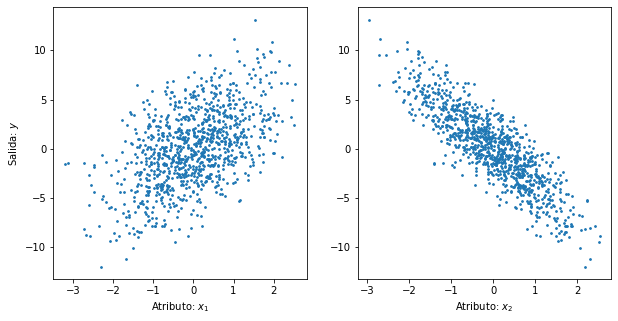

In [5]:
fig, axes = plt.subplots(1, 2, figsize = [10, 5])
axes[0].scatter(features[:, 0].numpy(), labels.numpy(), 3);
axes[0].set_xlabel(r"Atributo: $x_1$"); axes[0].set_ylabel(r"Salida: $y$");

axes[1].scatter(features[:, 1].numpy(), labels.numpy(), 3);
axes[1].set_xlabel(r"Atributo: $x_2$"); axes[0].set_ylabel(r"Salida: $y$");


## Preparando el conjunto de datos

Resolveremos el problema de regresión utilizando el método iterativo que vimos. 
Para esto necesitamos una función que sea capaz de generar los bloques, recibiendo como 
entrada el tamaño de los bloques. Ahora utilizaremos un iterador que ya viene 
en las librerias de `tensorflow`.

In [6]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

### Inicializamos los valores de los parámetros

El módulo `initializers` tiene ya codificados varios modos de inicializar parámetros. Por el momento sólo tenemos que 
definir el modo en que seran asignados los valores iniciales. Keras se encarga de establecer las dimensiones adecuadas una vez que se ejecuten los comandos necesarios. 

In [39]:
initializer = tf.initializers.RandomNormal(stddev=0.001, seed = 10)

In [128]:
def get_net(): 
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, 
                                  use_bias = False, 
                                  kernel_initializer=tf.keras.initializers.Zeros()))    
    return net

In [129]:
def train_model(data_iter, optimizer, batch_size, num_epochs): 
    net = get_net()
    loss = tf.keras.losses.MeanSquaredError()
    params_history = np.empty([num_epochs, 2])

    for epoch in tqdm(range(num_epochs)):
        for X, y in data_iter:
            with tf.GradientTape() as tape:
                l = loss(net(X, training=True), y)
            params_history[epoch,:] = net.trainable_variables[0].numpy().reshape(1,-1)
            grads = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))

        l = loss(net(features), labels)
        
    return params_history

### Definimos modelo y entrenamos

In [137]:
batch_size, num_epochs = 30, 10
eta = 0.09

data_iter = load_array((features, labels), batch_size)

  0%|          | 0/10 [00:00<?, ?it/s]

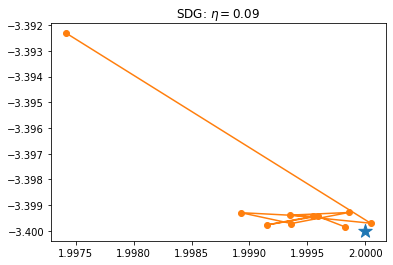

In [138]:
eta = .09
trainer = tf.keras.optimizers.SGD(learning_rate=eta)

params_history = train_model(data_iter, trainer, batch_size, num_epochs)

plt.scatter(true_w[0],true_w[1], marker  = "*", s = 200)
plt.plot(params_history[:,0], params_history[:,1], '-o', color='#ff7f0e')
plt.title('SDG: $\eta =$%2.2f'%eta);

  0%|          | 0/10 [00:00<?, ?it/s]

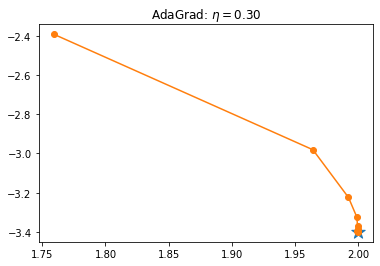

In [132]:
eta = .3
trainer = tf.keras.optimizers.Adagrad(learning_rate=eta)

params_history = train_model(data_iter, trainer, batch_size, num_epochs)

plt.scatter(true_w[0],true_w[1], marker  = "*", s = 200)
plt.plot(params_history[:,0], params_history[:,1], '-o', color='#ff7f0e')
plt.title('AdaGrad: $\eta =$%2.2f'%eta);

  0%|          | 0/10 [00:00<?, ?it/s]

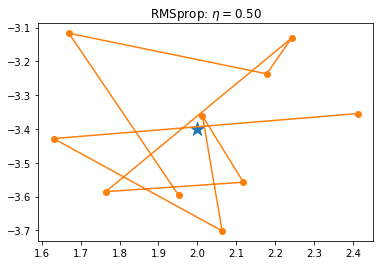

In [133]:
eta = .5
trainer = tf.keras.optimizers.RMSprop(learning_rate=eta, rho = 3./4)

params_history = train_model(data_iter, trainer, batch_size, num_epochs)

plt.scatter(true_w[0],true_w[1], marker  = "*", s = 200)
plt.plot(params_history[:,0], params_history[:,1], '-o', color='#ff7f0e')
plt.title('RMSprop: $\eta =$%2.2f'%eta);

  0%|          | 0/10 [00:00<?, ?it/s]

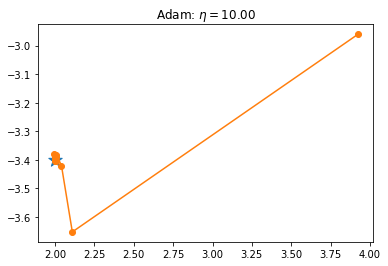

In [134]:
eta = 10
trainer = tf.keras.optimizers.Adam(learning_rate=eta)

params_history = train_model(data_iter, trainer, batch_size, num_epochs)

plt.scatter(true_w[0],true_w[1], marker  = "*", s = 200)
plt.plot(params_history[:,0], params_history[:,1], '-o', color='#ff7f0e')
plt.title('Adam: $\eta =$%2.2f'%eta);